# Comparing Nico and Guillaume's SGD code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import sympy as sym
from sympy.vector import CoordSys3D
from sympy.utilities.lambdify import lambdastr, implemented_function, lambdify
from glob import glob

from sys import path
path.insert(0, "lib")
from integrators import Integrator

%load_ext autoreload
%autoreload 2

In [2]:
class SGD_dataset(Integrator):
    """
    Same as SGD, except that the dataset (xb, yb) is specified at each time step, instead of being randomly generated
    """
    def update_dataset(self, w_old, xb, yb):
        xi_xx = np.mean(xb*xb)
        xi_xy = np.mean(xb*yb)
        grad0 = (xi_xx * self.q(w_old) - xi_xy) * self.grad_q(w_old)
        
        w_new = w_old - self.lr*grad0
        
        if self.pbc:
            w_new = w_new % 1.
            
        return w_new

    def evolve_dataset(self, dataset):
        wc = self.w[-1]
        for xb, yb in dataset:
            xb = np.array(xb.numpy())
            yb = np.array(yb.numpy())[0]
            wc = self.update_dataset(wc, xb, yb)
            self.w.append(wc)

### Guillaume

In [3]:
import torch
import ast

from sys import path
path.insert(0, "lib_guillaume")
import onedmodel as guil

In [49]:
# Initialise
w0 = 0.3
seed = 1
model = guil.PolyModel(w0=w0, seed=seed, wmin=-.5, wmax=.5, d1=1, d2=2)

nSGD = 1
nsamples = 5
shuffle = False # True: data gets suffled around
batch_size = 1
lr = 0.01
sgd_runner = guil.SGDPolyRunner(nSGD=nSGD, nsamples=nsamples, seed=seed, 
                                shuffle=shuffle, 
                                batch_size=batch_size, 
                                auto=True)
df, dataset = sgd_runner.generate_trajectories(model)


In [44]:
std_epsilon = 1.
lr = 0.02
q = lambda w: (w+w0)*(w-w0)**2.
grad_q = lambda w: (w-w0)**2. + 2.*(w+w0)*(w-w0)
w_init = df.trajectory.values[0][0]
sgd = SGD_dataset(std_epsilon, lr, q, grad_q, w_init, batch_size, seed)

In [45]:
sgd.evolve_dataset(dataset.dataset)

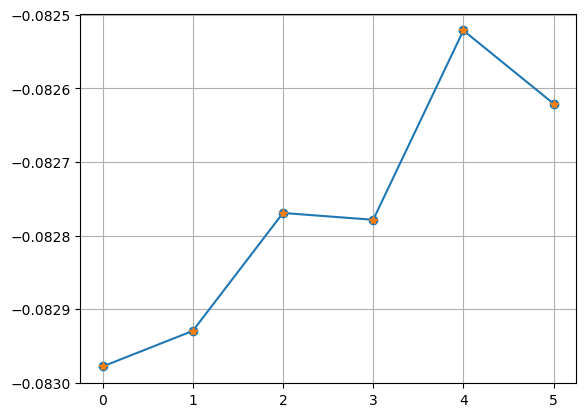

In [53]:
for data in df.trajectory:
    plt.plot(data, '-o')
plt.plot(sgd.w, '*')
plt.grid()
plt.show()